# Exploratory Analysis of Sentiment140

In [1]:
# Install the contractions module for this notebook session
!pip install contractions

     |████████████████████████████████| 284 kB 589 kB/s            
     |████████████████████████████████| 321 kB 8.7 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=106872 sha256=973949991eb01c3787325562baf98f7007f9db9636d0daa071c3b23967754789
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [2]:
import os
import re
import sys
import json
from typing import List
from datetime import datetime

# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# nltk and contractions are used during the tokenization process
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.tokenize.api import TokenizerI
from nltk.stem import StemmerI, WordNetLemmatizer
import contractions


import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import seaborn as sns
from wordcloud import WordCloud

# sklearn imports
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_curve, RocCurveDisplay, precision_score, recall_score


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You may need to download nltk corpora used in this notebook
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

In [3]:
# We will use a list of English stopwords as provided by the associate nltk corpus
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
STOPWORDS

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [4]:
from typing import Callable
from time import time, perf_counter


class LogEntry:
    """
    A simple logging class for use with the timeit method to track function performance.
    Currently supports a simple number of calls and total time spent by the associated
    method call.
    """
    
    def __init__(self, method_name: str = "unknown", calls: int = 0, total_time: float = 0.00):
        self.method_name = method_name
        self.calls = calls
        self.total_time = total_time

    def add_run(self, run_time):
        self.calls += 1
        self.total_time += run_time
        
    def get_average(self):
        return self.total_time / self.calls
        
    def __str__(self):
        return f"{self.method_name} | Runs: {self.calls} | Total Time: {self.total_time:.3f} ms"
    
    def __repr__(self):
        return f"LogEntry< '{self.method_name}' - calls: {self.calls} - total_time: {self.total_time:.3f} ms>"
    

def timeit(method: Callable[..., any]) -> Callable[..., float]:
    """
    A simple decorator to measure the execution speed of the decorated method.
    
    :param method: A method of which we would like to measure the performance.
    :type method: Callable object
    
    :return: A callable that wraps the initial method with the timed version.
    :type return: Callable
    """
    def timed(*args, **kw):
        ts = perf_counter()
        result = method(*args, **kw)
        # te = time()
        run_time = perf_counter() - ts
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            if name in kw['log_time']:
                # Create a 2 item list that just increments
                kw['log_time'][name].add_run(run_time)
            else:
                kw['log_time'][name] = LogEntry(name, 1, run_time)
        else:
            print(f"{repr(method.__name__)}: {run_time:.2f} s")
        return result
    return timed
log_times = {}

## Import the Dataset

We will be using the publicly available Kaggle version of the [sentiment140 dataset](https://www.kaggle.com/kazanova/sentiment140) <cite>[1]</cite> for this exercise. 

[1]: Go, A., Bhayani, R. and Huang, L., 2009. Twitter sentiment classification using distant supervision. CS224N Project Report, Stanford, 1(2009), p.12.

In [5]:
# Import the dataset with the proper encoding and labels
DS_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DS_ENCODING = "ISO-8859-1"

df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',
                 encoding=DS_ENCODING, names=DS_COLUMNS,
                 dtype={'sentiment': 'int8'})

df = df[['sentiment', 'text']]
# Positive tweets have a value of 4 that we will convert to 1 for a binary column
df['sentiment'] = df['sentiment'].replace(4, 1)
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## Prepare the lemmatizer and tokenizer from NLTK

The project utilizes the publicly available NLTK library for natural language processing.
We will use a list of stopwords as provided in NLTK to reduce the token count. Stopwords are
words that have been shown to add little to no contextual value during natural language processing.
Reducing feature size in this manner will benefit us later when we move to TF-IDF vectorization.

# Create Functions to Tokenize Text

The function `stem_and_tokenize` performs the following steps:
1. Replace any fully qualified URLs with the word url
> e.x. - [http://www.foo.bar] -> 'url'
2. Replace any instances of user handles with USER
> e.x. - '@fooBar42' -> 'user'
3. Remove any non alphanumeric characters
> e.x. - ';ab&' -> 'ab'
4. Pass the text through the SnowballStemmer and ignore stop words
    * nltk.stem.WordNetLemmatizer
    * nltk.stopwords('english')
5. Append stemmed words to the return list
6. Additional options to log performance times and specify n-gram length are provided

In [6]:
# Setup compiled regular expressions for tokenization
NON_ALNUM_RE = re.compile(r'[^a-zA-Z0-9]')
USER_RE = re.compile('@[^\s]+')
HTTP_URL_RE = re.compile("((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)")
SPACES_RE = re.compile('[\s]+')

# Setup tokenizer and lemmatizer
wn_lemmatizer = WordNetLemmatizer()
tw_tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True)

@timeit
def make_ngrams(words: List[str], n: int = 1, log_time: dict = None, log_name: str = None) -> List[str]:
    """
    Return a list of n-grams from the provided tokenized list. The list
    should not be sorted and represent an initial ordering of the text
    as it was originally encountered. If no argument is passed, the default
    will be to return the list of unigrams.
    
    :param words: A list of tokens to be converted into n-grams
    :type words: int
    :param n: N-gram argument to specify size of the window
    :type n: int
    
    :return: The list of n-grams for the provided list of tokens
    :type return: List[str]
    """
    if n == 1 or not words or n > len(words):
        return words
    # Otherwise we process n-gram windows and proceed
    n_grams = []
    for i in range(len(words) - n + 1):
        n_grams.append('_'.join(words[i:i+n]))
    return n_grams


@timeit
def stem_and_tokenize(origin_text: str,
                      lemmatizer: WordNetLemmatizer,
                      tokenizer: TokenizerI,
                      n_grams: int = 1,
                      log_time=None) -> List[str]:
    """
    The make_tokens function accepts a string containing origin text 
    and returns a list of tokens by work. The preprocessing step will
    perform the following transformations to the supplied text:
    
        1. Replace any fully qualified URLs with the word url
            e.x. - 'http://www.foo.bar' -> 'url'
        2. Replace any instances of user handles with USER
            e.x. - '@fooBar42' -> 'user'
        3. Remove any non alphanumeric characters
            e.x. - ';ab&' -> 'ab'
        4. Pass the text through the lemmatizer and ignore stop words
            * nltk.stem.WordNetLemmatizer
            * nltk.stopwords('english')
        5. Append stemmed words to the return list
    
    :param origin_text: An example text sentence to be tokenized for analysis.
    :type origin_text: str
    :param lemmatizer: A lemmatizer to be used during the tokenization process
    :type lemmatizer: nltk.stem.api.StemmerI -> must implement the stem method
    :param tokenizer: A tokenizer for splitting the text into tokens. Default is TweetTokenizer.
    :type tokenizer: nltk.tokenize.api.TokenizerI
    :param n_grams: N-grams to create for the tokens, default is 1
    
    :return: The stemmed, tokenized version of the example text with user handles, urls, and stop words removed.
    :type return: List[str]
    """
    text = origin_text.lower()
    # Replace the URLs and usernames
    text = HTTP_URL_RE.sub(' url', text)
    text = USER_RE.sub(' user', text)
    # Expand contractions before additional processing
    text = contractions.fix(text)
    # Replace non alpha numeric characters with empty string
    text = NON_ALNUM_RE.sub(' ', text)
    text = SPACES_RE.sub(' ', text)
    # Tokenize the processed text and make n-grams
    tokens = tokenizer.tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in STOPWORDS]
    return make_ngrams(tokens, n_grams, log_time=log_time)

def make_tokens(row_data: str, n_grams: int = 1) -> List[str]:
    """
    A simple wrapper function for use with vectorized apply methods.
    
    :param row_data: String data that represents an individual text example.
    :type row_data: str
    :param n_grams: An integer value specifying the length of n-gram
    :type n_grams: int
    
    :return: A list of tokens produced by stemming and tokenizing the provided row_data
    :type return: List[str]
    """
    return stem_and_tokenize(row_data, wn_lemmatizer, tw_tokenizer, n_grams=n_grams,log_time=log_times)

# Split the original text into a token list

In [7]:
# We will use a local reference to the len function as a small optimization
local_len = len

df_processed = df.copy()
df_processed['tokens'] = df_processed['text'].apply(make_tokens)
df_processed['text_length'] = df_processed['text'].apply(local_len)

## Setup N-gram Strings

In [8]:
n_gram_options = {
    'unigrams': 1,
    'bigrams': 2,
    'trigrams': 3,
}

for n_gram, n in n_gram_options.items():
    df_processed[n_gram] = df_processed['tokens'].apply(lambda x: ' '.join(make_ngrams(x, n,
                                                                                       log_time=log_times,
                                                                                       log_name=f"{n_gram}_stem")))
    # Add string length, token:text ratio for unigrams only
    if n == 1:
        df_processed[f"{n_gram}_length"] = df_processed[n_gram].apply(len)
        df_processed['unigram_to_text'] = df_processed[f"{n_gram}_length"] / df_processed['text_length']

df_processed.head()

,sentiment,text,tokens,text_length,unigrams,unigrams_length,unigram_to_text,bigrams,trigrams
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...","[user, url, awww, bummer, shoulda, got, david,...",115,user url awww bummer shoulda got david carr th...,53,0.460870,user_url url_awww awww_bummer bummer_shoulda s...,user_url_awww url_awww_bummer awww_bummer_shou...
1,0,is upset that he can't update his Facebook by ...,"[upset, cannot, update, facebook, texting, mig...",111,upset cannot update facebook texting might cry...,76,0.684685,upset_cannot cannot_update update_facebook fac...,upset_cannot_update cannot_update_facebook upd...
2,0,@Kenichan I dived many times for the ball. Man...,"[user, dived, many, time, ball, managed, save,...",89,user dived many time ball managed save 50 rest...,55,0.617978,user_dived dived_many many_time time_ball ball...,user_dived_many dived_many_time many_time_ball...
3,0,my whole body feels itchy and like its on fire,"[whole, body, feel, itchy, like, fire]",47,whole body feel itchy like fire,31,0.659574,whole_body body_feel feel_itchy itchy_like lik...,whole_body_feel body_feel_itchy feel_itchy_lik...
4,0,"@nationwideclass no, it's not behaving at all....","[user, behaving, mad, cannot, see]",111,user behaving mad cannot see,28,0.252252,user_behaving behaving_mad mad_cannot cannot_see,user_behaving_mad behaving_mad_cannot mad_cann...


## Setup Methods to count word frequencies



In [9]:
from collections import Counter
from typing import Tuple, List, Dict

class FrequencyCollection:
    """
    A simple class that contains positive, negative, and total frequency counts
    for the provided string.
    """
    
    def __init__(self, all_counts: Dict[str, int], pos: Dict[str, int], neg: Dict[str, int]):
        self.all_counts = all_counts
        self.pos = pos
        self.neg = neg


def create_frequency_counts(feature_col: str) -> Tuple[Dict[str, int], Dict[str, int], Dict[str, int]]:
    """
    Create frequency count dictionary for the given feature column from the
    processed data frame.
    
    :param feature_col: The name of the feature column of which to count.
    :type feature_col: str
    :return: A tuple consisting of all counts, positive counts, and negative counts
    :rtype: tuple on Python 3.x containing three dict objects
    """
    all_counts = Counter()
    pos_counts = Counter()
    neg_counts = Counter()

    def count_tokens_from_list(sentiment: int, tokens: List[str]):
        if sentiment == 0:
            neg_counts.update(tokens)
        else:
            pos_counts.update(tokens)
        all_counts.update(tokens)
            

    if feature_col == 'tokens':
        df_processed.loc[df_processed['sentiment'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x))
        print("Finished counting negative tokens")
        df_processed.loc[df_processed['sentiment'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x))
        print("Finished counting positive tokens")
    else: 
        df_processed.loc[df_processed['sentiment'] == 0, feature_col].apply(lambda x: count_tokens_from_list(0, x.split(' ')))
        print(f"Finished counting negative {feature_col.title()}")
        df_processed.loc[df_processed['sentiment'] != 0, feature_col].apply(lambda x: count_tokens_from_list(1, x.split(' ')))
        print(f"Finished counting positive {feature_col.title()}")
    
    return FrequencyCollection(all_counts, pos_counts, neg_counts)


def word_cloud_from_dict(title: str,
                         sub_title: str,
                         word_counts: Dict[str, int],
                         fig: Figure, subplot: Tuple[int, int, int],
                         max_words: int = 100,
                         bg_color: str = 'white'):
    """
    Create a word cloud from the supplied frequency dictionary.
    
    The word cloud from dict function expects a dictionary representing 
    the frequency of a given word in the given context. The function adds
    an image to the provided subplot location.
    
    """
    # Create the word cloud image
    wc = WordCloud(max_words=max_words, width=1600, height=800,
                   collocations=False,
                   background_color=bg_color)
    wc.generate_from_frequencies(word_counts)
    
    # Add to the provided figure and subplot
    fig.add_subplot(*subplot)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis('off')
    plt.title(f"{title.title()}\n{sub_title.title()} Sentiment", fontdict={'fontsize': 20})

    
def make_frequency_clouds(fig: Figure, pos_counts: Dict[str, int], neg_counts: Dict[str, int],
                                  feature_col: str, rows: int, cols: int, idx: int, max_words: int = 100):
    """
    A helper function for creating word cloud comparisons using the positive or negative
    labeled text examples. Resulting images will be output to the relative path of ./images/
    for use in associated documentation.
    
    :param cleaned_data: The cleaned data frame for the sentiment140 training data. Assumed to be
                         in the sorted order such that the first 800000 rows contain negative examples.
    :type clened_data: pandas.core.frame.DataFrame
    :param feature_col: The feature column name that we want to make a word cloud from. This column must
                        contain a space separated string value for processing.
    :type feature_col: string
    """
    # Observation tells us that these words don't contribute much to the informative value of the figures
    word_cloud_from_dict(feature_col, "Negative", neg_counts, fig, (rows, cols, (2 * idx + 1)), bg_color='red')
    word_cloud_from_dict(feature_col, "Positive", pos_counts, fig, (rows, cols, (2 * idx + 2)), bg_color='whitesmoke')


In [10]:
# Create simple frequency count objects to work with

token_counts = create_frequency_counts('tokens')
bigrams_counts= create_frequency_counts('bigrams')
trigrams_counts = create_frequency_counts('trigrams')

frequency_counts= [token_counts, bigrams_counts, trigrams_counts]

Finished counting negative tokens
Finished counting positive tokens
Finished counting negative Bigrams
Finished counting positive Bigrams
Finished counting negative Trigrams
Finished counting positive Trigrams


# Word Cloud Visualizations

Word cloud visualizations provide instant feedback on the most commonly occurring words based on sentiment.
One observation of note is that even when considering trigrams single words rise to the top as most frequently occurring. 
What we can learn is that even in short text, a single word may exhibit the most value for sentiment polarity classification.
User comes up as the most commonly occurring word across all contexts due to the fact that all tweets are preceeded by @username.
Ultimately the decision to keep user was made as it proved to add value to the predictions made.

In [ ]:
for feature_col in n_gram_options.keys():
    fig = plt.figure(figsize=(16, 16))
    rows, cols = 2, 2

    make_frequency_clouds(fig, token_counts.pos, token_counts.neg, feature_col, rows, cols, 0)

    fig.suptitle(f"Word Cloud Visualizations: {feature_col.title()}", fontsize=24)
    fig.tight_layout()
plt.show()
plt.close()

## Histogram: Most Common N-Grams by Sentiment

<P>Each visualization shows the 25 most common n-grams occuring in the following contexts:</P>  

* Tokens(unigrams)
* Bigrams
* Trigram

In [12]:
def top_count_histogram(token_counts: FrequencyCollection,
                        feature_col: str,
                        n_most_common: int,
                        figsize: Tuple[int, int] = (16, 16)):
    """
    Create histograms for the top n most common tokens occurring in both
    positive an negative sentiment examples. The images will be plotted to
    the same figure and saved to disk.
    
    
    :param token_counts: A FrequencyCollection object containing all, positive,
                         and negative frequency counts.
    :type token_counts: FrequencyCollection
    :param feature_col: The name of the feature being evaluated for the histogram.
    :type feature_col: int
    :param n_most_common: The number of examples to consider for the top n most common.
    :type n_most_common: int
    """

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=figsize)
    
    # Plot histogram of the top 25 most common words for positive sentiment
    pos_token_df = pd.DataFrame(token_counts.pos.most_common(n_most_common), columns=['token', 'count'])
    pos_token_df[pos_token_df['token'] != ''].plot(x='token', y='count', kind='bar', title="Positive Token Counts", ax=axes[0])
    # Plot histogram of the top 25 most common words for negative sentiment
    neg_token_df = pd.DataFrame(token_counts.neg.most_common(n_most_common), columns=['token', 'count'])
    neg_token_df[neg_token_df['token'] != ''].plot(x='token', y='count', kind='bar', title="Negative Token Counts", ax=axes[1])
    for ax in axes:
        ax.title.set_size(20)
    fig.tight_layout(pad=10.0)
    fig.suptitle(f"Frequency Histogram: {feature_col.title()}", fontsize=24)
    plt.show()
    plt.close()

## Top 25 Token Counts - Unigrams

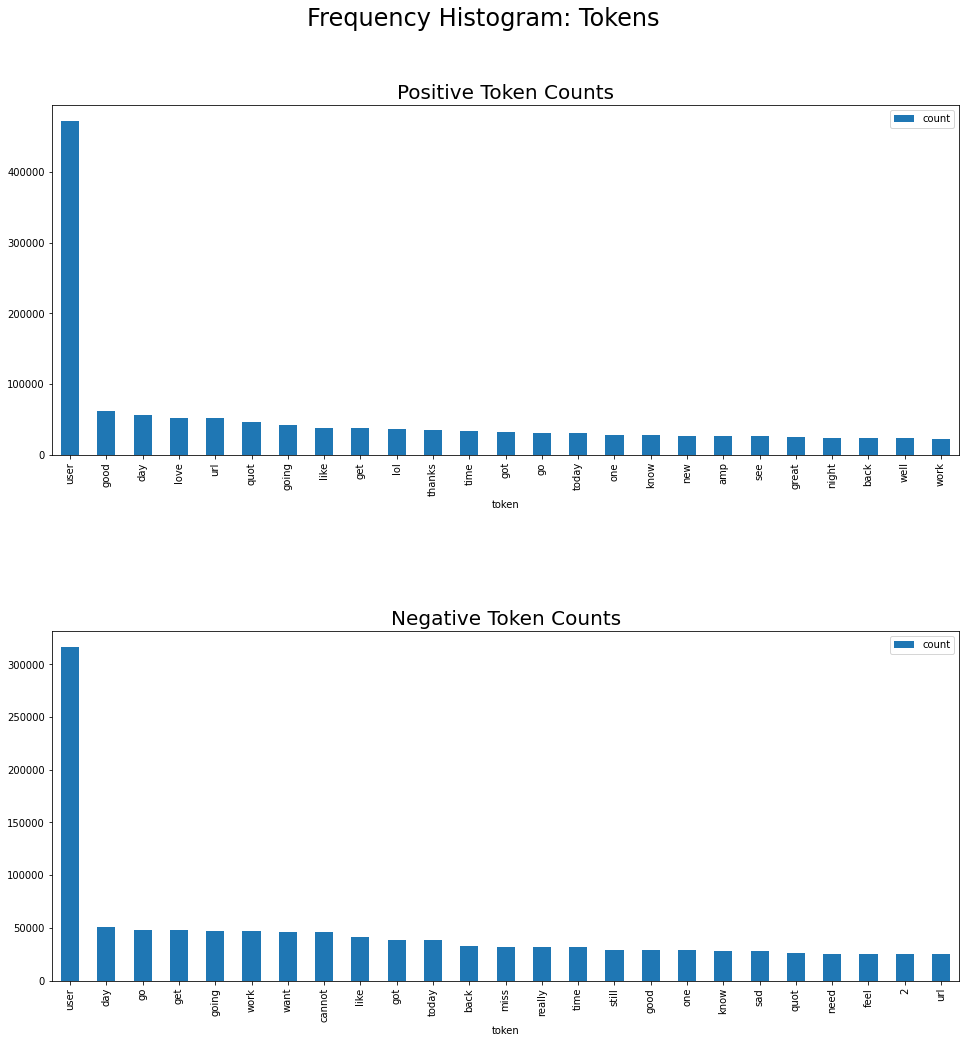

In [13]:
top_count_histogram(token_counts, 'tokens', 25)

## Top 25 Token Counts - Bigrams

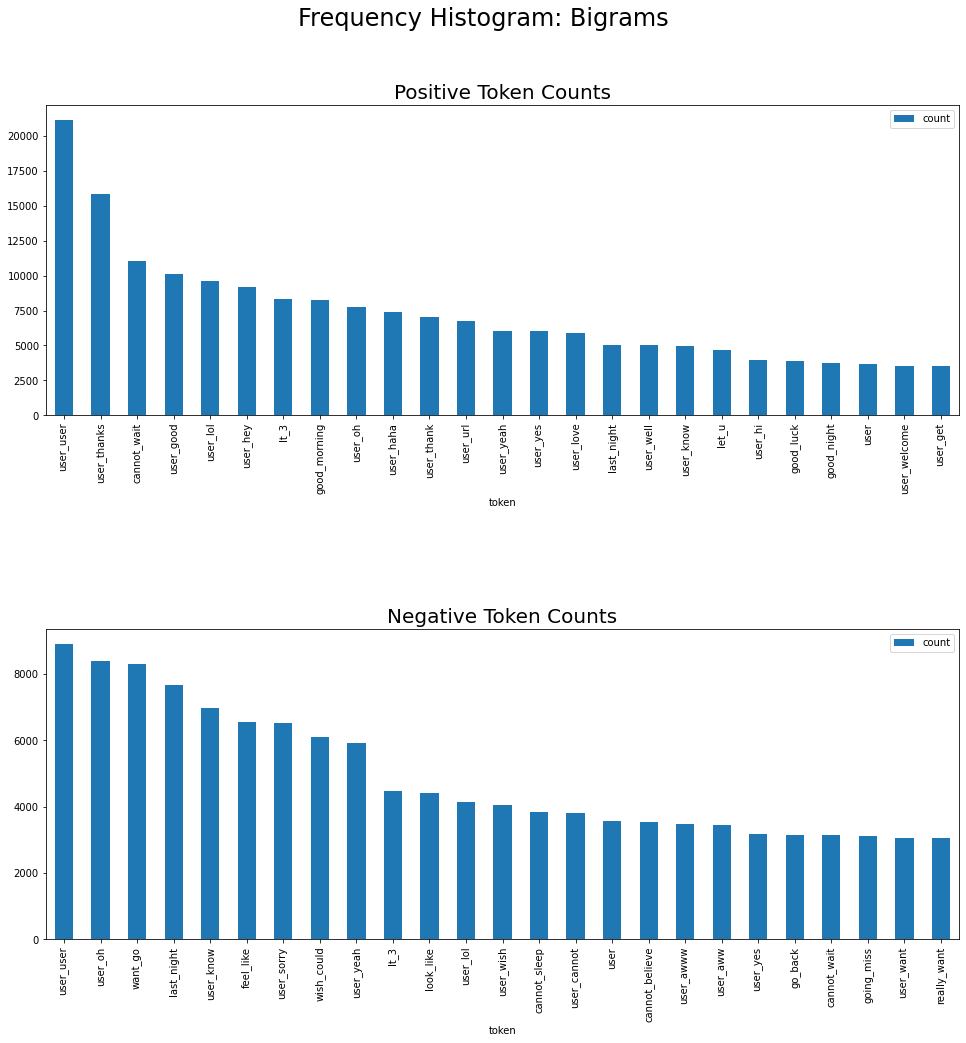

In [14]:
top_count_histogram(bigrams_counts, 'bigrams', 25)

## Top 25 Token Counts - Trigrams

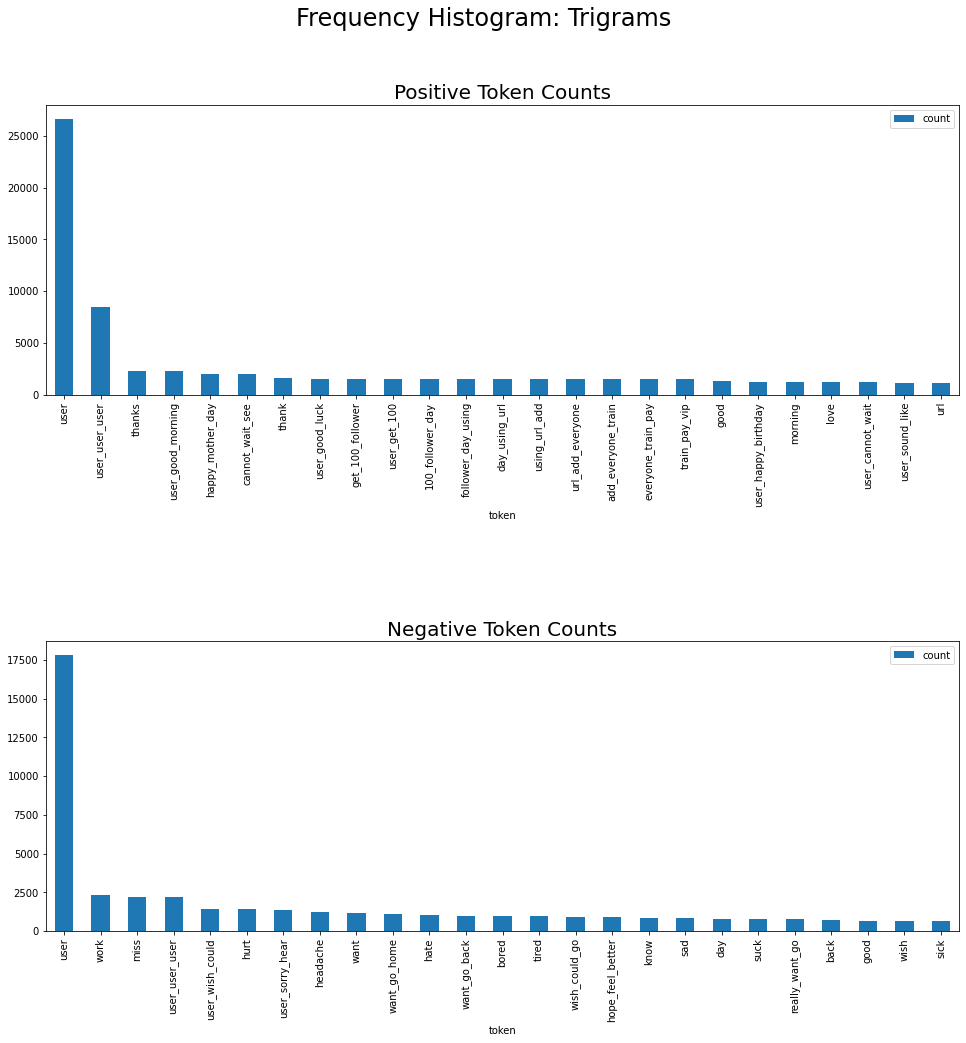

In [15]:
top_count_histogram(trigrams_counts, 'trigrams', 25)

# Split preprocessed training data

For model training and evaluation we don't need the list of strings.
We only need the joined string counterparts of the tokenized data.
* Drop the tokens list from the dataframe
* Sample the data into new sizes
* We can drop the original text in favor of the token strings
* Numeric attributes will not be needed either at this stage

## Create random samplings of various sizes to show value of data

Naive Bayes models benefit from larger volumes of data. 
Three additional random samples are generated from the full training set.
Each sampling will be put through the same evaluation and scoring process to illustrate the value of increased data.

In [16]:
columns_to_drop = ['text', 'unigram_to_text', 'bigrams', 'trigrams']

df_processed.drop(columns_to_drop, axis=1, inplace=True)
df_processed.head()

,sentiment,tokens,text_length,unigrams,unigrams_length
0,0,"[user, url, awww, bummer, shoulda, got, david,...",115,user url awww bummer shoulda got david carr th...,53
1,0,"[upset, cannot, update, facebook, texting, mig...",111,upset cannot update facebook texting might cry...,76
2,0,"[user, dived, many, time, ball, managed, save,...",89,user dived many time ball managed save 50 rest...,55
3,0,"[whole, body, feel, itchy, like, fire]",47,whole body feel itchy like fire,31
4,0,"[user, behaving, mad, cannot, see]",111,user behaving mad cannot see,28


In [17]:
def samples_with_plot(origin_df: pd.DataFrame, sample_sizes=[1], make_plots: bool = False):
    """
    Create sample dataframes from the supplied original data frame with the
    specified sample sizes and plot a bar chart to view the distribution.
    Sample data frames are created as deep copies so that they may be used
    in distinct transformation tasks without poluting all referenced objects.
    
    Args:
        origin_df[pd.DataFrame]: The original dataframe from which to generate samples
        sample_sizes[List[int | float]]: The sample sizes of which to take. Default is [1]
    Returns:
        sample_frames: A list of data frame samples that have been deep copied from origin.
    """
    
    rows = int(np.ceil(len(sample_sizes) / 2))
    fig, axes = plt.subplots(rows, 2, figsize=(16, rows * 4))
    sample_frames = []

    for ax, sample in zip(axes.ravel(), sample_sizes):
        sample_df = origin_df.sample(frac=sample, random_state=42).copy(deep=True)
        sample_frames.append(sample_df)
        sample_df.groupby('sentiment').count().plot(
            kind='bar',
            ax=ax,
            legend=False,
        )
        ax.set_xlabel(f"Sample Size: {sample * 100:.2f}%", fontsize=16)
        ax.set_ylabel("Example Count", fontsize=12)

    # Remove the unused axes from the figure before producing output
    fig.suptitle("Sentiment Polarity:\n0-Negative / 1-Positive", fontsize=20)
    plt.show()
    plt.close()
    return sample_frames

## Create Assorted Sample Sizes
The processed text is split into various sizes for model training and evaluation.
The visualization confirms the same distribution across all sample sizes.

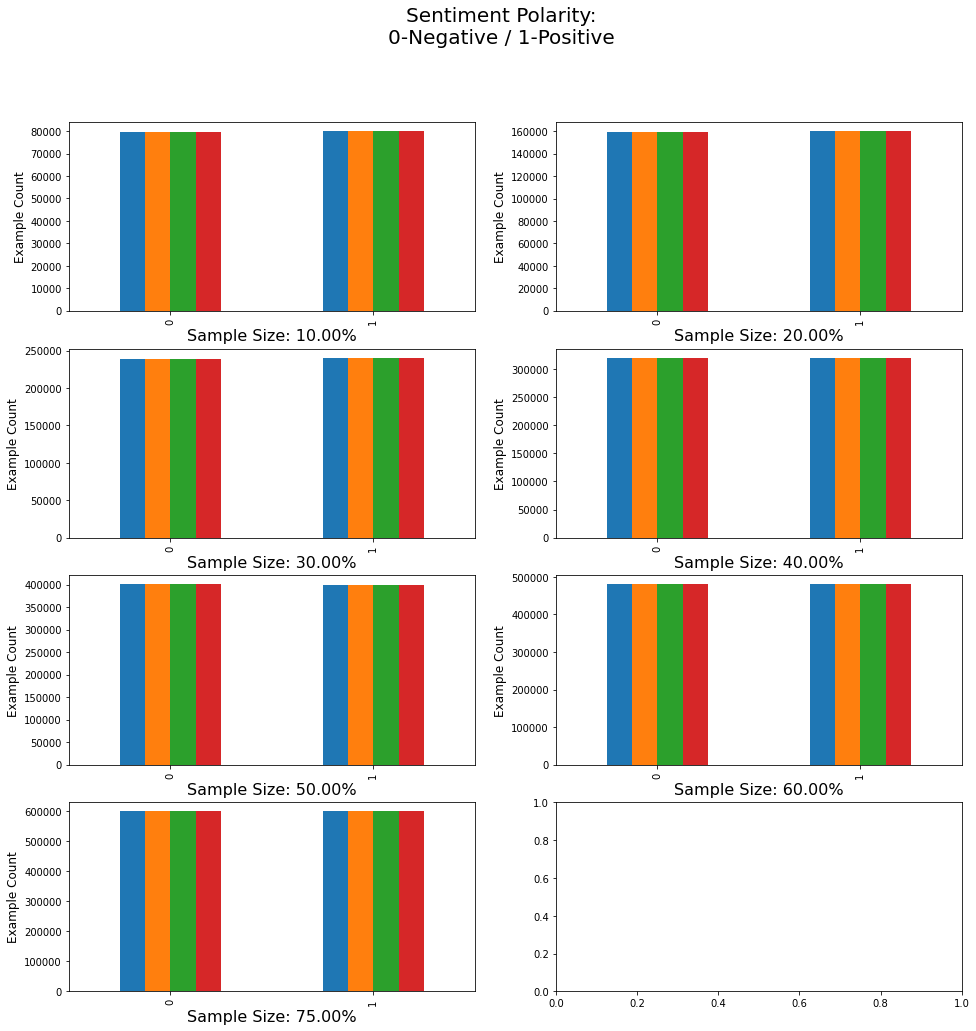

In [18]:
samplings = samples_with_plot(df_processed, sample_sizes=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.75], make_plots=True)
samplings.append(df_processed.sample(frac=1, random_state=42))

sample_frames = list(zip(["10", "20", "30", "50", "60", "75","100"], samplings))

# Descriptive Data Method

With the numerical attributes of text length and token length we will
explore if there are any relationships seen through K-means

## K Means Clustering with the numerical features

The numerical features of text length, number of tokens, and length of the unigram will be explored.

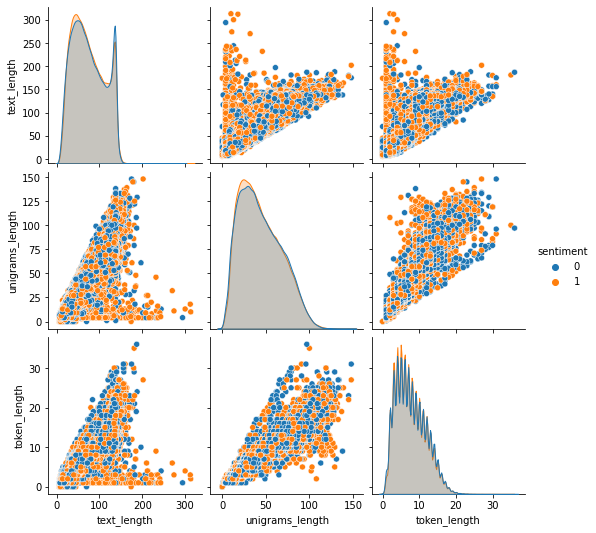

In [19]:
k_means_cols = ['sentiment', 'text_length', 'unigrams_length']

# Do text & token length show any relationship?

X_train = sample_frames[2][1][k_means_cols].copy()
X_train['token_length'] = sample_frames[2][1]['tokens'].apply(local_len)

sns.pairplot(X_train, hue='sentiment', diag_kind='kde')

The visualizations show both positive and negative examples exhibit similar distributions across `token_length`, `text_length`, and `unigrams_length`.
The pair plots do not indicate any direct relationships between these values and the actual sentiment of the example.

In [20]:
# Splinter off the target from the training data
y_train = X_train['sentiment'].copy()
X_train.drop(['sentiment'], axis=1, inplace=True)

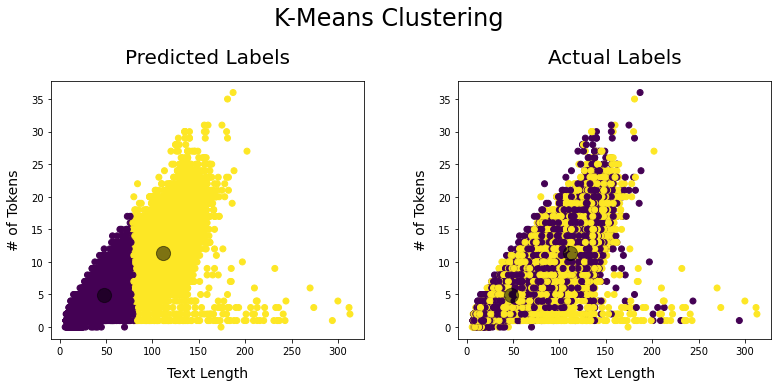

In [21]:
h = 0.02
C = 1.0

km_clf = KMeans(n_clusters=2, random_state=42)
km_clf.fit(X_train[['text_length', 'token_length']])

y_means = km_clf.predict(X_train[['text_length', 'token_length']])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(X_train['text_length'], X_train['token_length'], c=y_means)
centers = km_clf.cluster_centers_
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
ax1.set_xlabel("Text Length", fontdict={'size': 14}, labelpad=10)
ax1.set_ylabel("# of Tokens", fontdict={'size': 14}, labelpad=10)
ax1.set_title(f"Predicted Labels", fontdict={'size': 20}, pad=18)

ax2.scatter(X_train['text_length'], X_train['token_length'], c=y_train)
centers = km_clf.cluster_centers_
ax2.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
ax2.set_xlabel("Text Length", fontdict={'size': 14}, labelpad=10)
ax2.set_ylabel("# of Tokens", fontdict={'size': 14}, labelpad=10)
ax2.set_title(f"Actual Labels", fontdict={'size': 20}, pad=18)

fig.tight_layout(pad=5.0)
fig.suptitle(f"K-Means Clustering",  fontsize=24)
plt.show()

K-means clustering is performed on the data using the `text_length` and `token_length` attributes.
The predicted groupings are shown in the plot on the left hand side.
Comparing the clusters to the actual classifications on the right hand side we can surmise this method does not appear to be a great choice for this problem

# Model Evaluation and Selection

In addition to the stemming and tokenizing of the text examples, we must convert each example into a numerical vector.
The `sklearn.feature_extraction.text` module provides two classes specifically designed for this purpose.
The `CountVectorizer` class produces a vector using the *Bag of Words* model where each attribute represents the occurrences of a specific word.
The `TfidfVectorizer` class combines the concepts of *term frequency* and *inverse document frequency* to highlight the value of key phrases or words [(Wikipedia)](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).  

## Methods to Evaluate & Train Model

In [22]:
def evaluate_model(model, X_test, y_test, fig, subplot, labeling):
    """
    Evaluate the performance of the given model against the provided test prediction set.
    Prints out the model classification report from Scikit learn to provide critical
    information about the performance of the model.
    
    :param model: A sci-kit learn classification model that has already been fit.
    :type model: sklearn.base.BaseEstimator
    :param X_test: A sparse nd.array that has been transformed using TfidVectorizer
    :type X_test: np.ndarray.sparse
    :return: Dictionary of results produced by the classification report
    :rtype: dict[str, dict[str, float]]
    """
    # Predict results
    label_font = {
        'size': 14
    }
    
    title_font = {
        'size': 20
    }
    y_pred = model.predict(X_test)
    
    # Produce report and confusion matrix for plotting
    report = classification_report(y_test, y_pred)
    cf_matrix = confusion_matrix(y_test, y_pred)
    
    cats = ['Negative', 'Positive']
    groupings = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    grouping_pct = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    
    map_labels = [f"{name}\n{pct}" for name, pct in zip(groupings, grouping_pct)]
    # We need to reshape to match up with the original data from the confusion matrix
    map_labels = np.asarray(map_labels).reshape(2, 2)
    
    ax = fig.add_subplot(*subplot)
    sns.heatmap(cf_matrix, annot=map_labels, cmap='viridis', fmt='',
                xticklabels=cats, yticklabels=cats, ax=ax)
    plt.xlabel("Predicted Class", fontdict=label_font, labelpad=10)
    plt.ylabel("Actual Class", fontdict=label_font, labelpad=10)
    plt.title(f"Confusion Matrix\n{labeling}", fontdict=title_font, pad=18)
    return y_pred, report
    
    
@timeit
def train_model(model, x_train, y_train, log_time=log_times, log_name: str = None):
    """
    Simple wrapper class to allow logging of training times.
    """
    model.fit(x_train, y_train)
    
def evaluate_feature(clf, fig, subplot, X_train_set, X_test_set, y_train_set, y_test_set, log_name, labeling):
    results = train_model(clf, X_train_set, y_train_set, log_name=f"{log_name}")
    y_preds, report = evaluate_model(clf, X_test_set, y_test_set, fig, subplot, labeling)
    f1 = f1_score(y_test_set, y_preds)
    accuracy = (y_test_set == y_preds).sum() / len(y_preds)
    
    return y_preds, f1, accuracy, report

# Drop Unused Features

We will only be using the unigrams moving forward so we can safely drop unused features to reduce our
memory footprint.

In [23]:
unused_features = ['tokens', 'text_length', 'unigrams_length']

for label, frame in sample_frames:
    frame.drop(unused_features, axis=1, inplace=True)
    print(f"{label} Columns: {frame.columns}")

10 Columns: Index(['sentiment', 'unigrams'], dtype='object')
20 Columns: Index(['sentiment', 'unigrams'], dtype='object')
30 Columns: Index(['sentiment', 'unigrams'], dtype='object')
50 Columns: Index(['sentiment', 'unigrams'], dtype='object')
60 Columns: Index(['sentiment', 'unigrams'], dtype='object')
75 Columns: Index(['sentiment', 'unigrams'], dtype='object')
100 Columns: Index(['sentiment', 'unigrams'], dtype='object')


## Model Selection

This cell runs trials across prospective models, vectorizers, and n-gram ranges. Results for each trial run
are logged in the list of `trial_logs` so that we can explore the results upon completion.

Classifiers
- BernoulliNB
- MultinomialNB

Vectorizers
- TfidfVectorizer
- CountVectorizer

N-Gram Ranges
- 1-1 Only single tokens are used (unigrams)
- 1-2 Tokens and Bigrams will be used

*Note- This cell can take a while to run*

In [24]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.23.2.


Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:39:56.926602
'train_model': 0.04 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.04 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


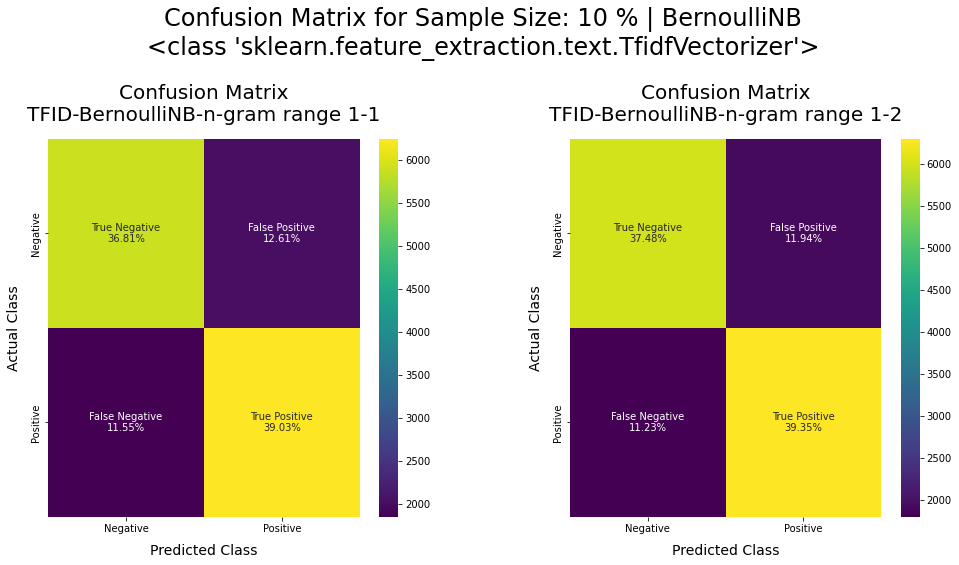

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:40:08.557586
'train_model': 0.03 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.03 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


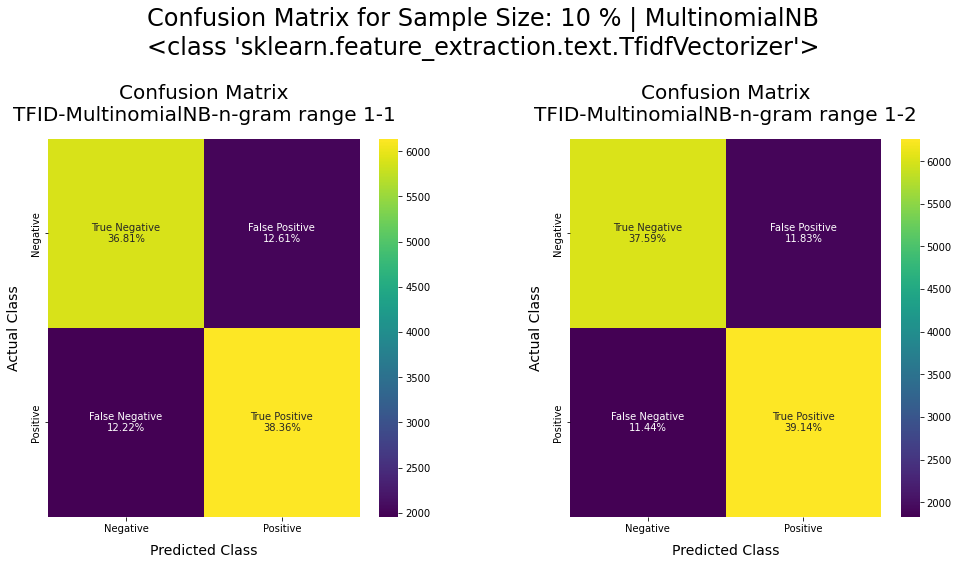

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:40:20.131358
'train_model': 0.04 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.04 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


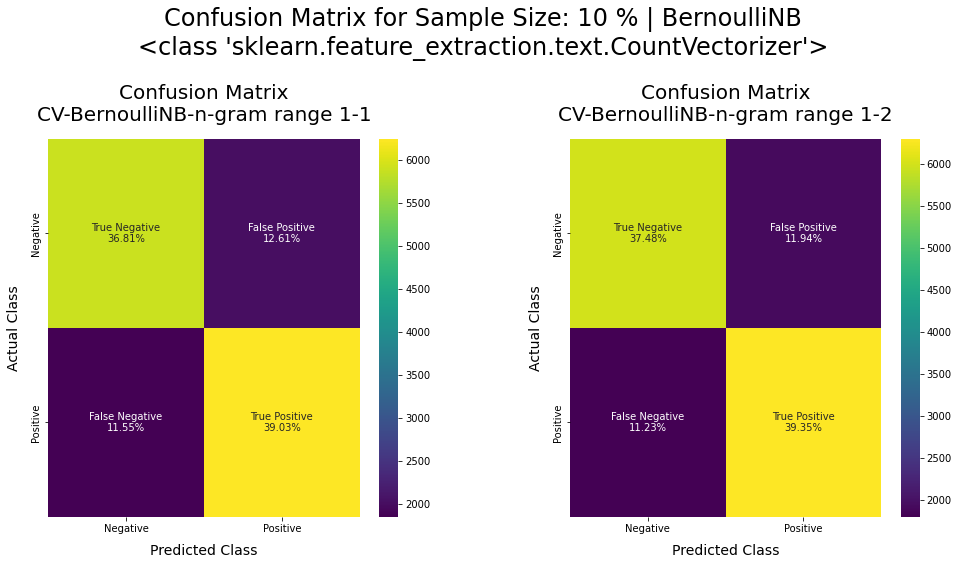

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:40:31.693541
'train_model': 0.03 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.03 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


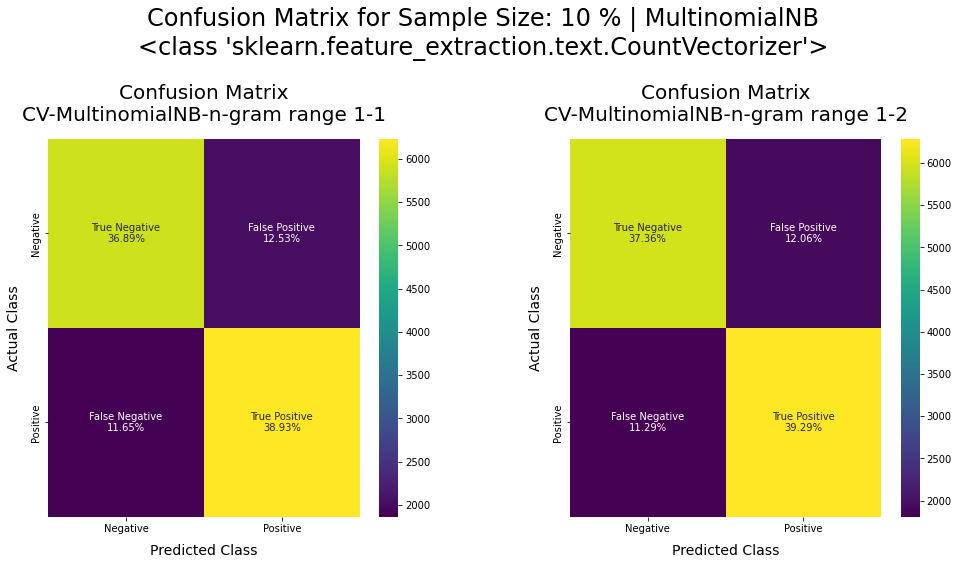

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:40:43.291575
'train_model': 0.08 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.09 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


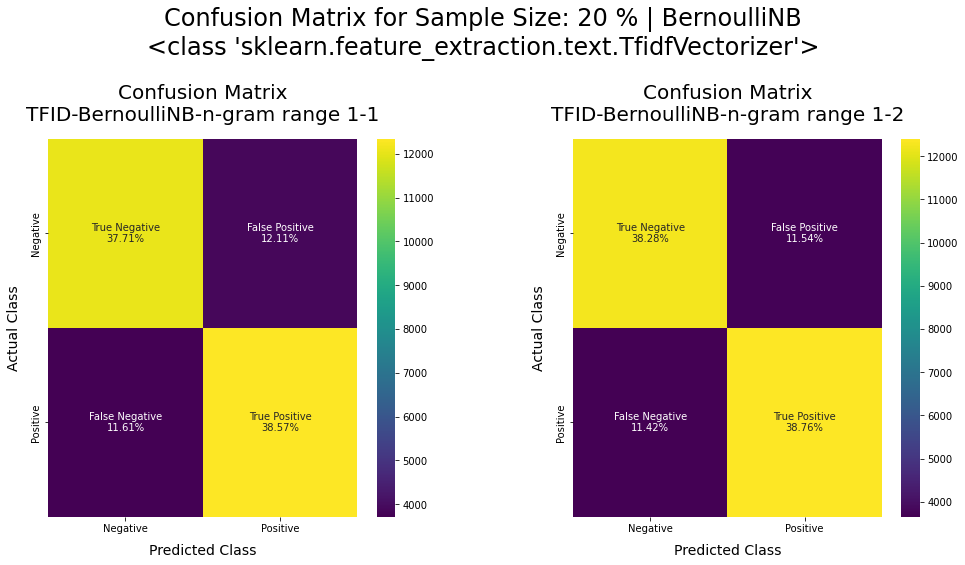

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:41:07.014813
'train_model': 0.06 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.07 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


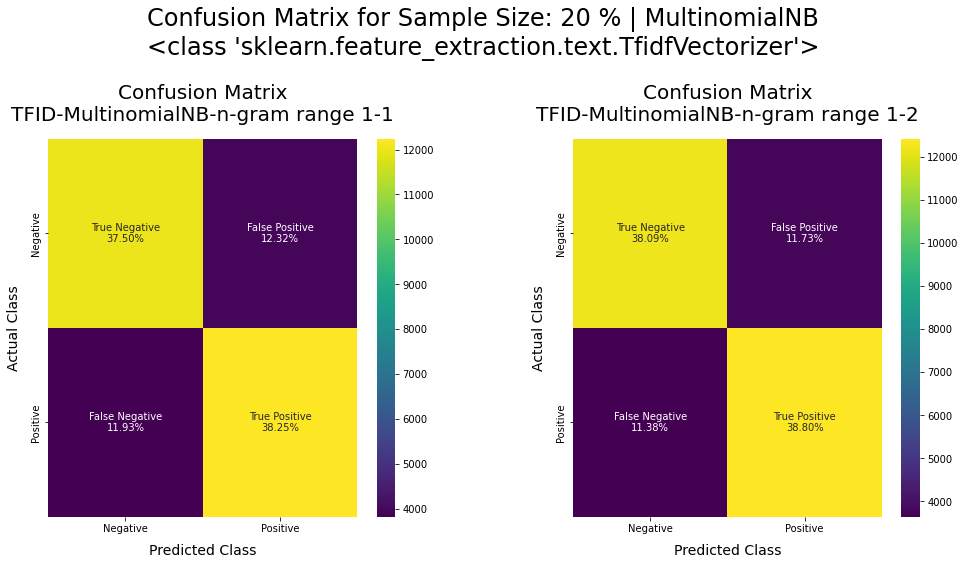

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:41:30.397848
'train_model': 0.07 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.08 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


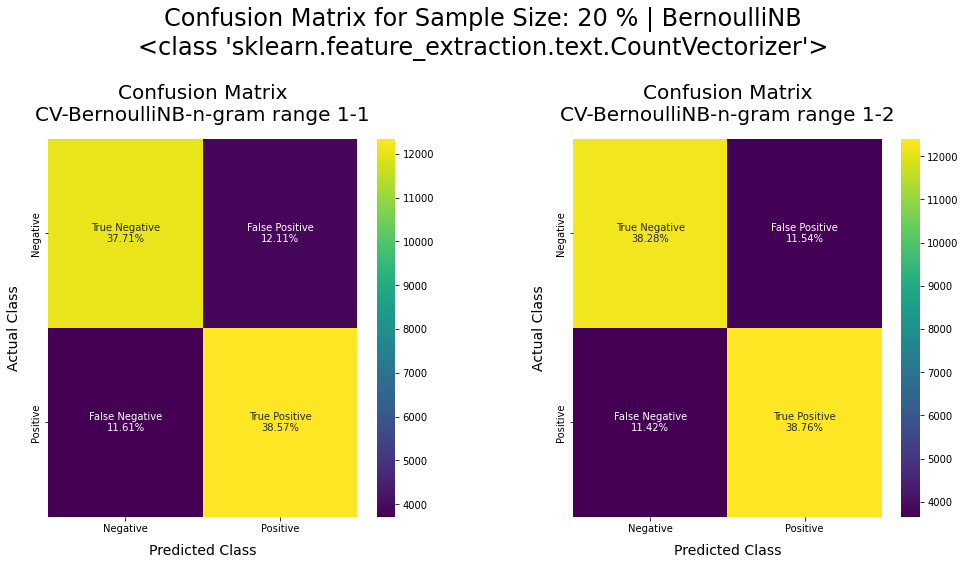

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:41:53.895135
'train_model': 0.06 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.06 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


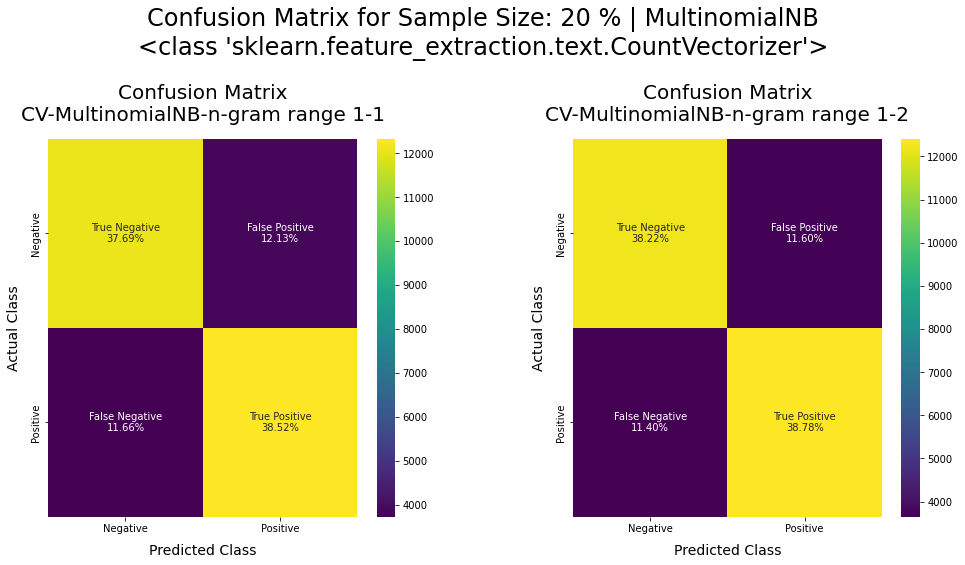

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:42:18.420237
'train_model': 0.12 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.14 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


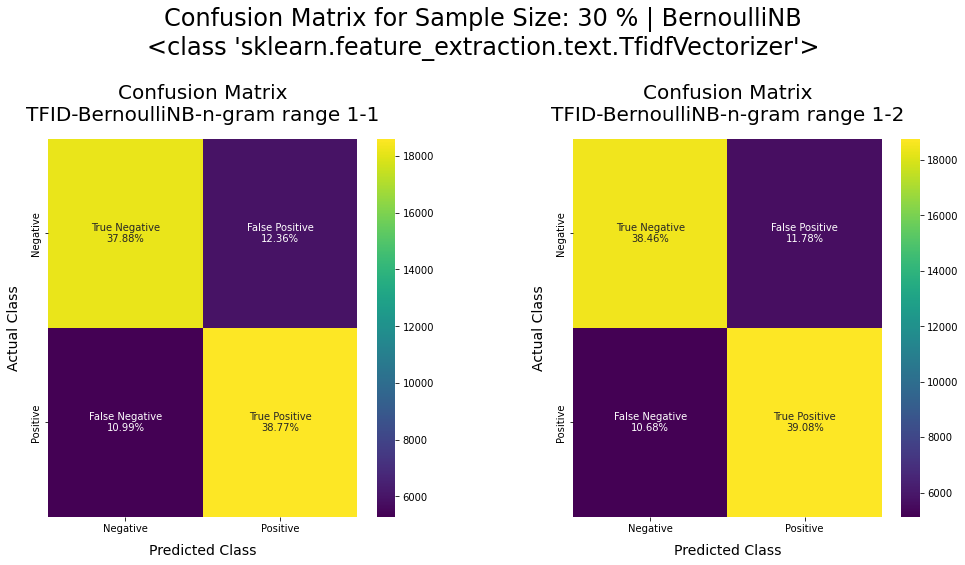

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:42:53.868227
'train_model': 0.09 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.11 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


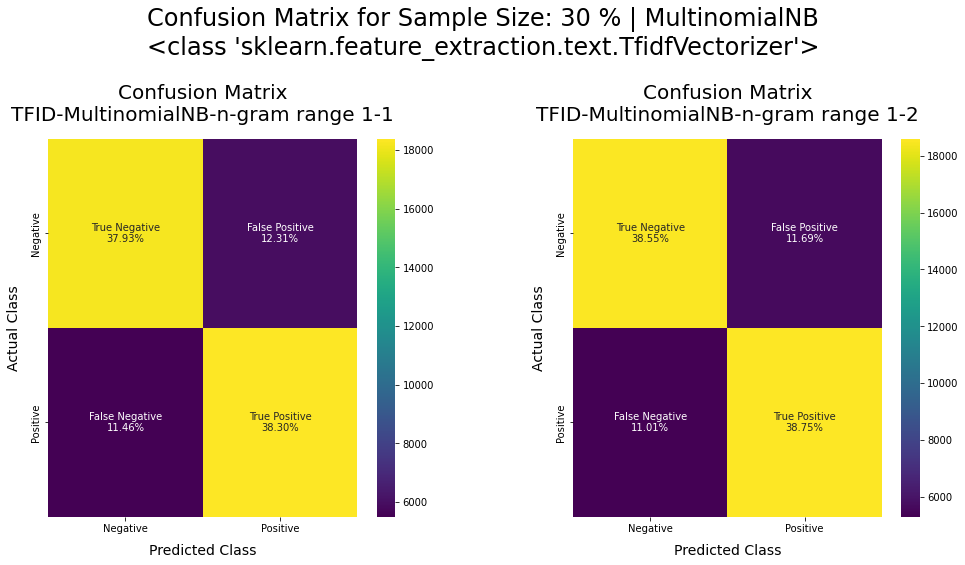

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:43:29.457297
'train_model': 0.11 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.13 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


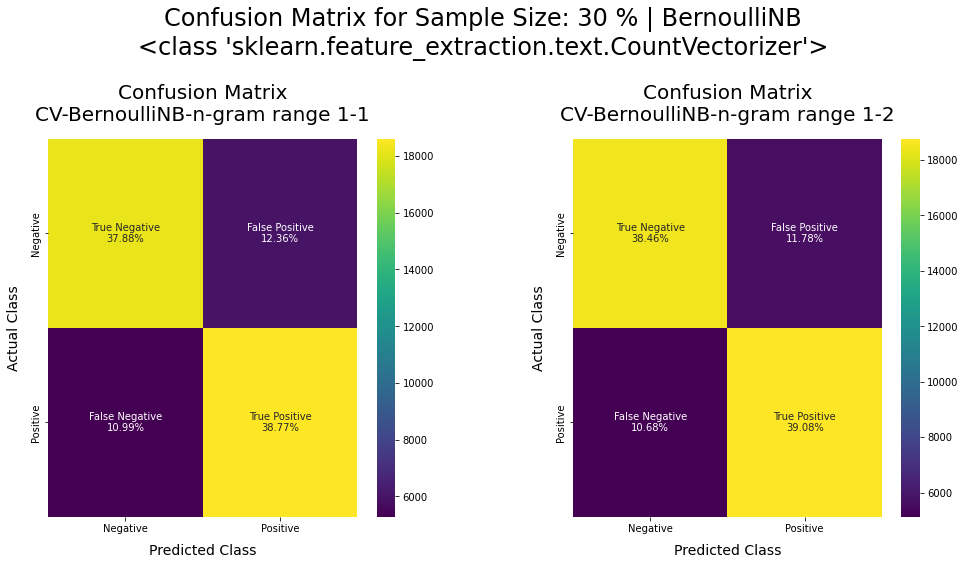

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:44:05.129899
'train_model': 0.09 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.10 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


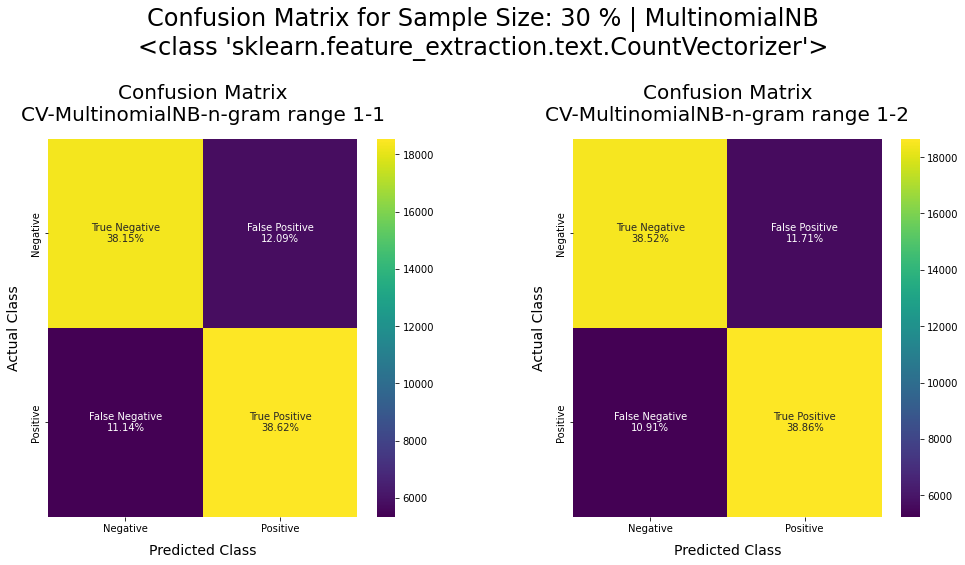

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:44:41.190757
'train_model': 0.16 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.20 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


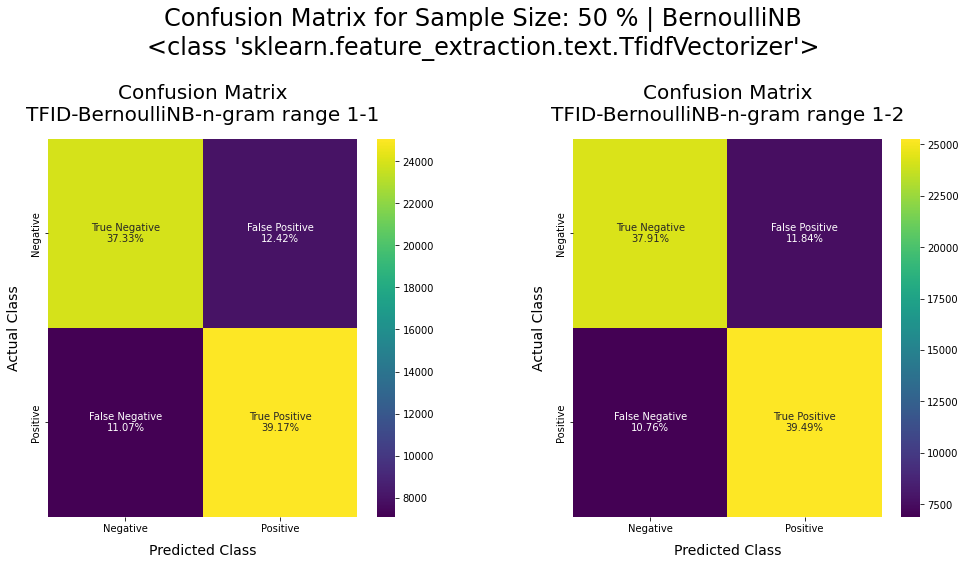

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:45:29.331994
'train_model': 0.12 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.15 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


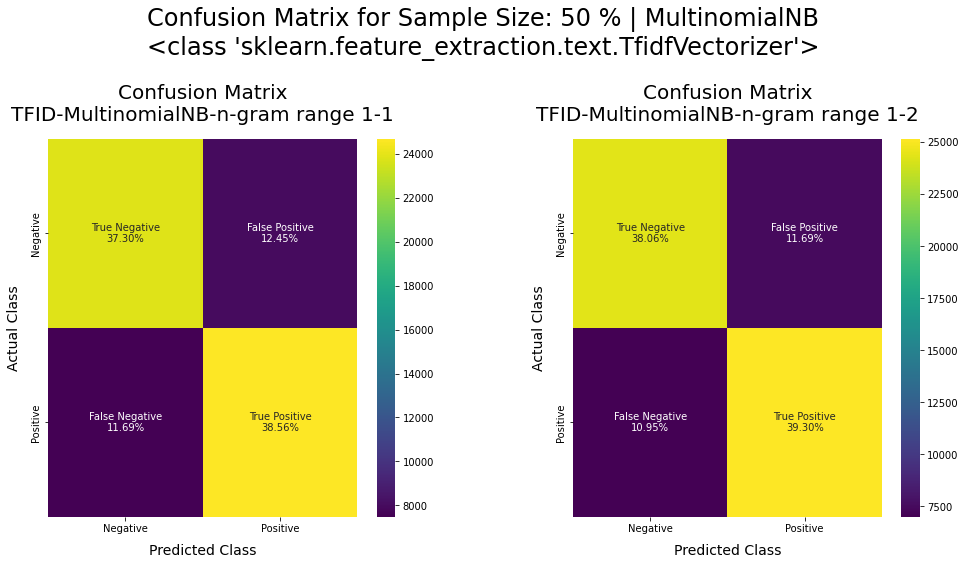

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:46:17.962485
'train_model': 0.15 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.18 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


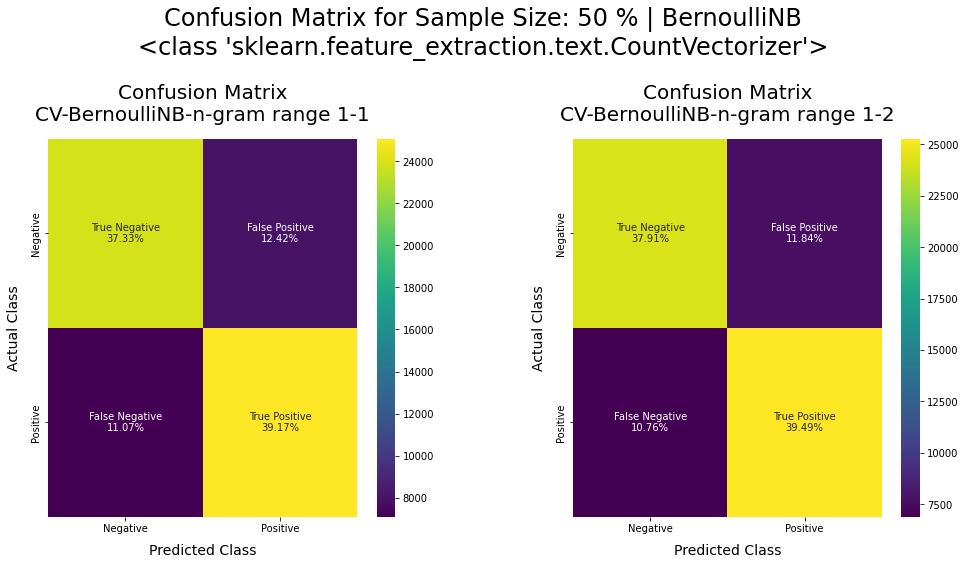

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:47:05.755706
'train_model': 0.12 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.13 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


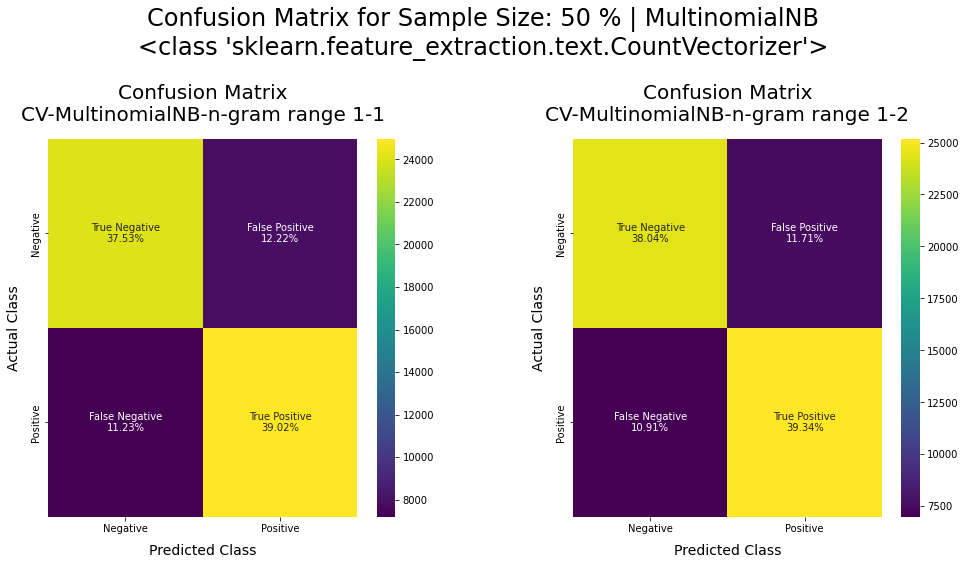

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:47:55.407563
'train_model': 0.20 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.25 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


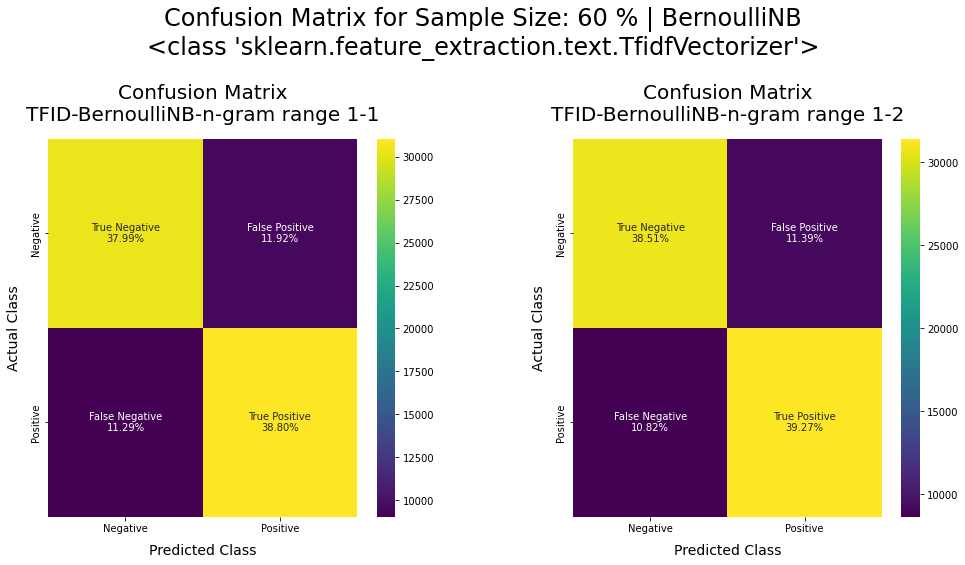

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:48:56.142000
'train_model': 0.16 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.19 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


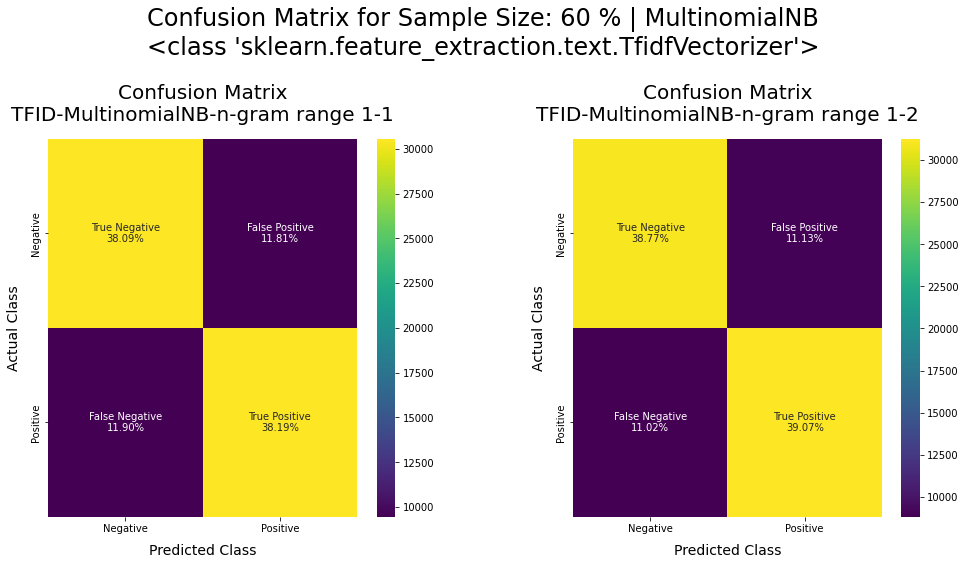

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:49:58.425296
'train_model': 0.19 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.24 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


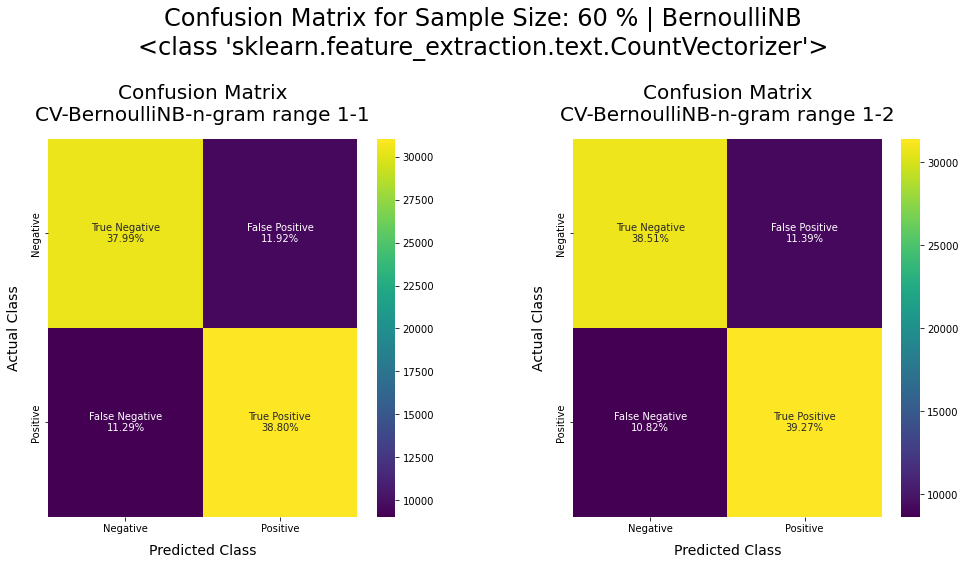

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:50:58.965467
'train_model': 0.14 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.18 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


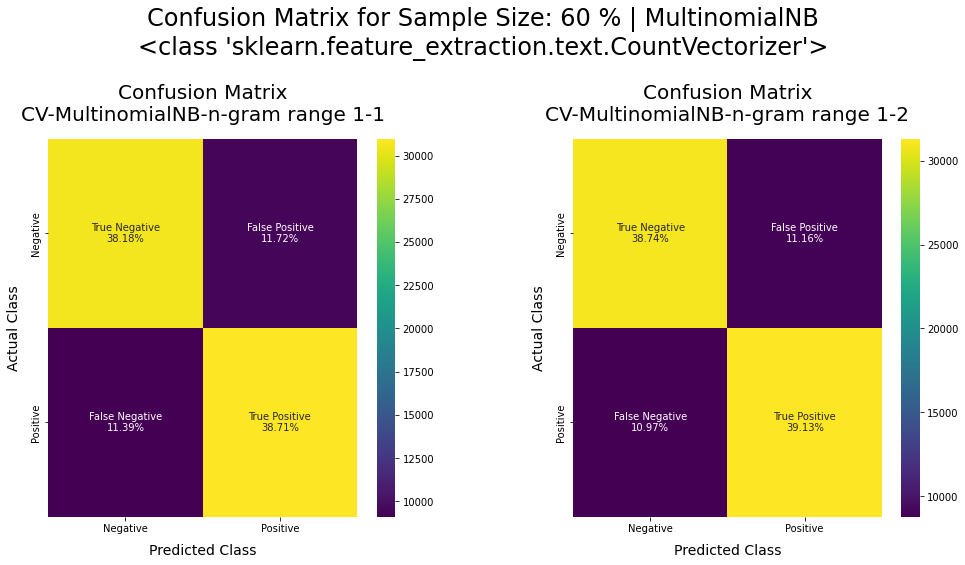

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:51:59.360548
'train_model': 0.25 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.33 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


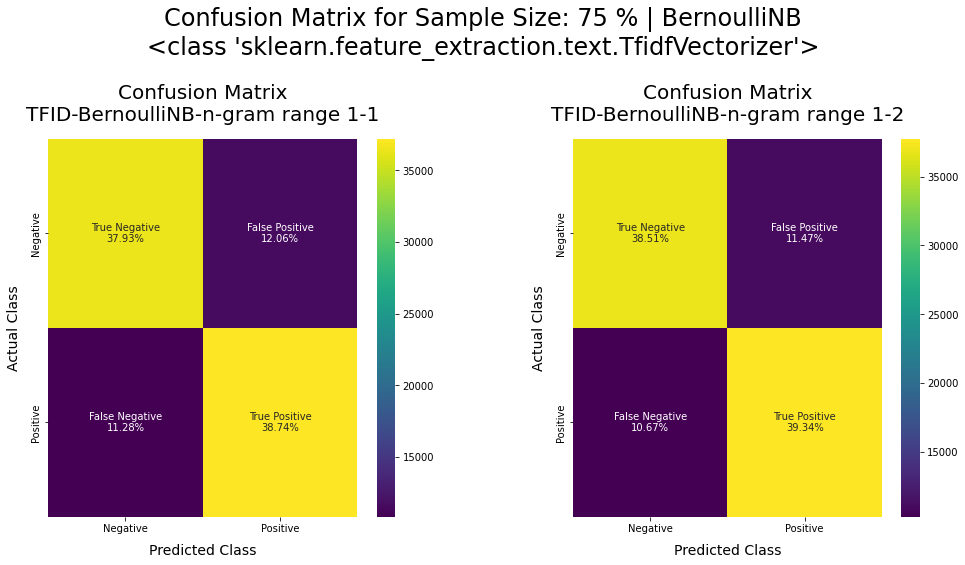

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:53:12.852885
'train_model': 0.19 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.23 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


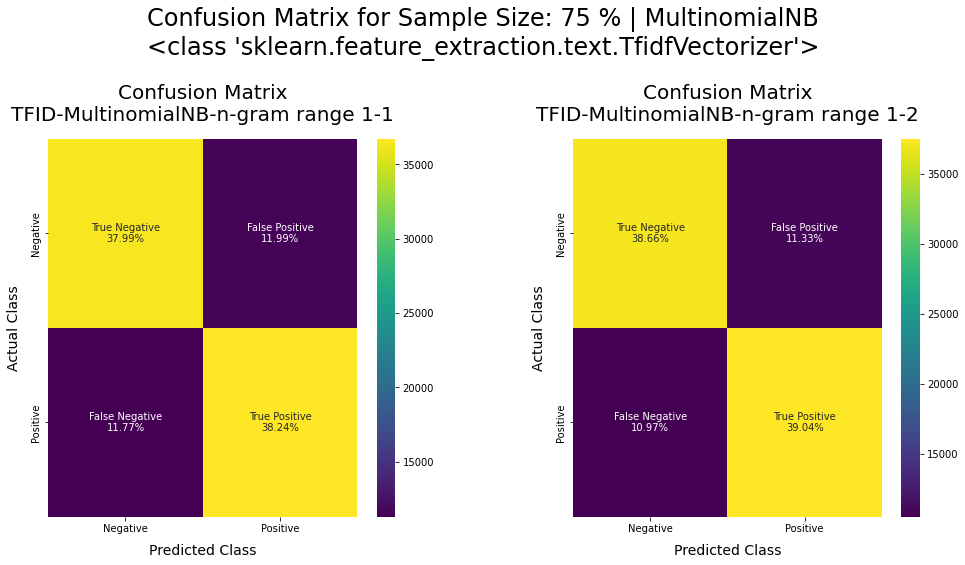

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:54:27.102484
'train_model': 0.23 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.29 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


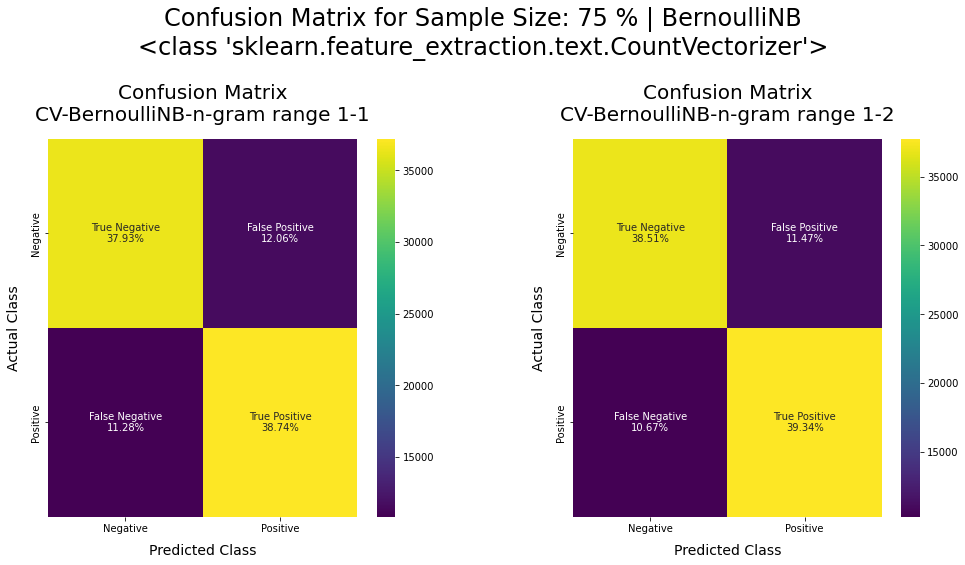

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:55:40.388792
'train_model': 0.17 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.21 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


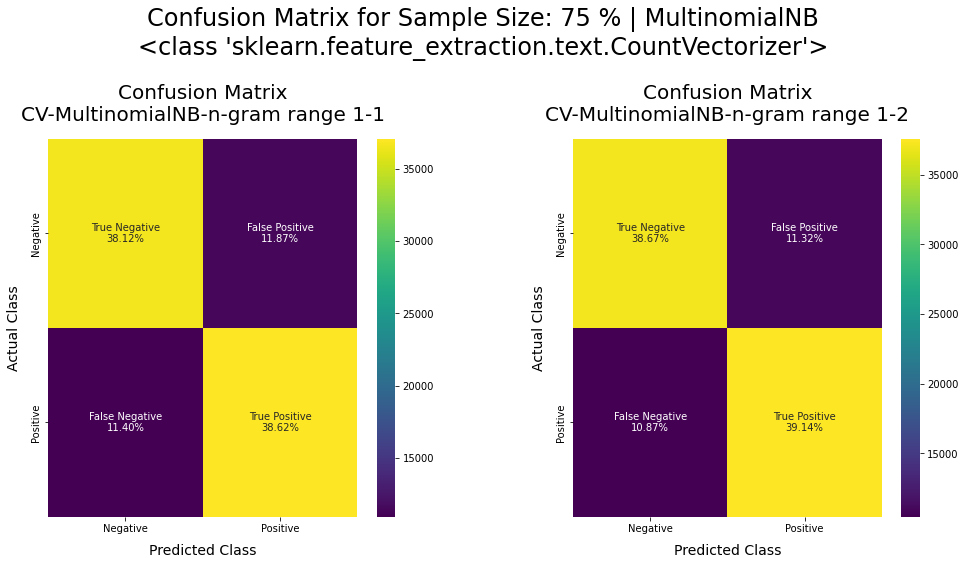

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:56:52.475370
'train_model': 0.32 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.41 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


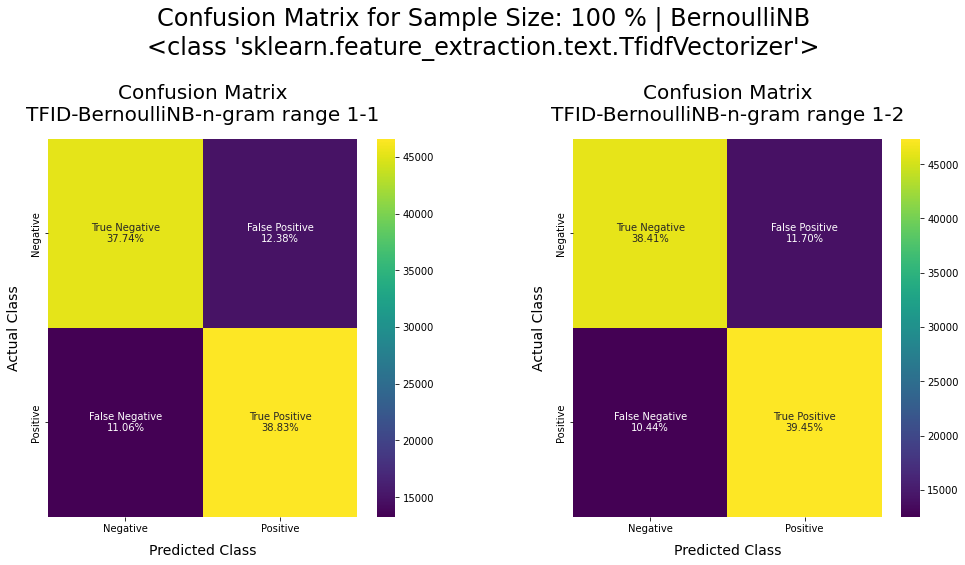

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-2022-02-19 23:58:25.302288
'train_model': 0.24 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-1
'train_model': 0.33 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.TfidfVectorizer'>-ngram-1-2


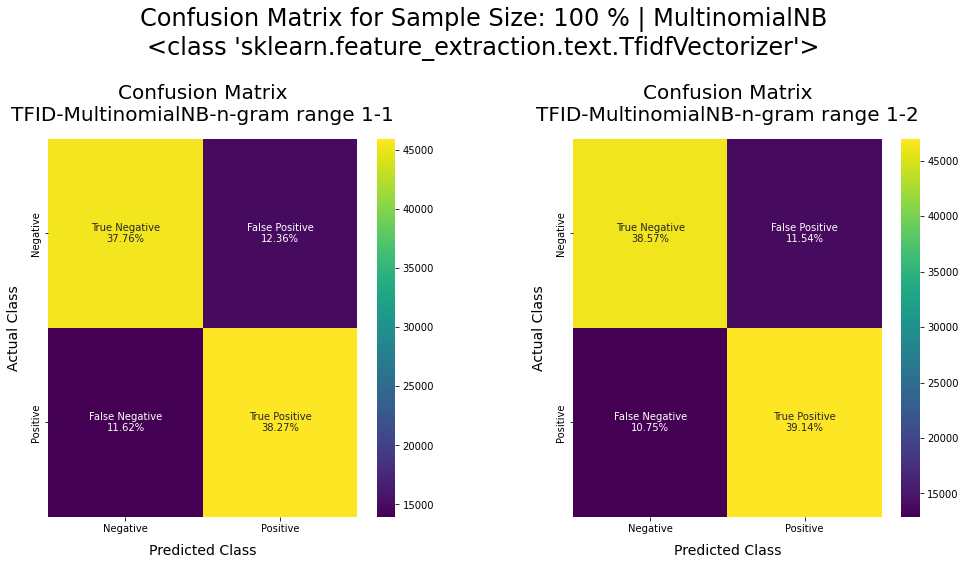

Beginning trials for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-19 23:59:58.536039
'train_model': 0.30 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.38 s
Trial complete for BernoulliNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


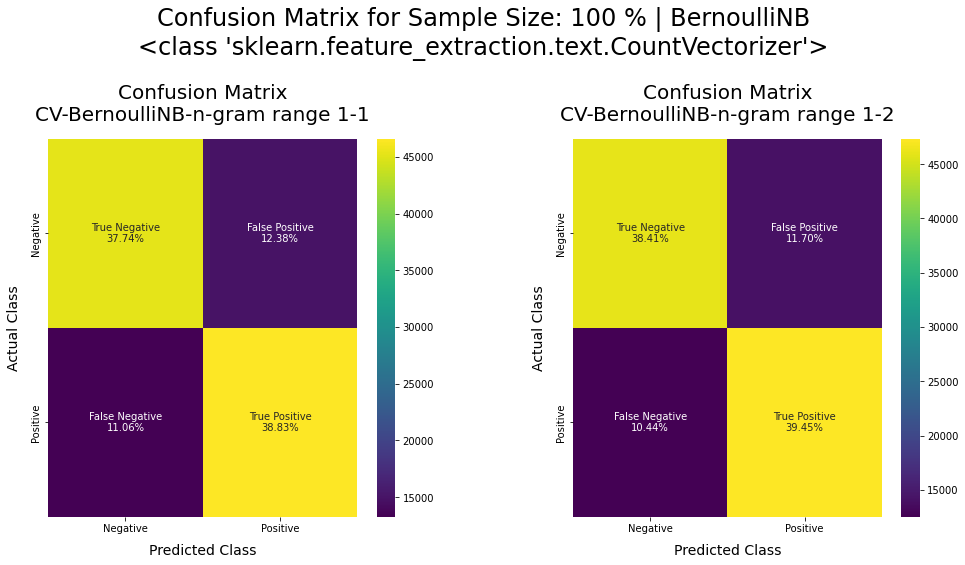

Beginning trials for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-2022-02-20 00:01:32.490737
'train_model': 0.22 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-1
'train_model': 0.30 s
Trial complete for MultinomialNB-<class 'sklearn.feature_extraction.text.CountVectorizer'>-ngram-1-2


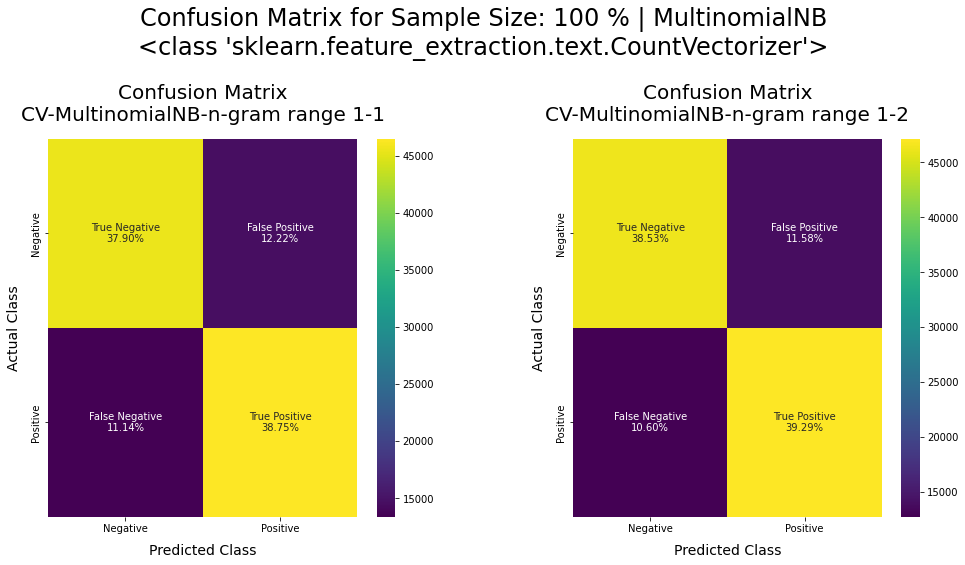

1388.536415664 seconds to run training


In [25]:
trial_logs = []
pred_list = []

clfs = [
    BernoulliNB(), 
    MultinomialNB()
]
vectorizers = [TfidfVectorizer, CountVectorizer]

testing_start = perf_counter()
# The evaluation process iterates over all of our sample sizes
for sample_size, current_frame in sample_frames:
    y = current_frame.sentiment
    X = current_frame.drop(['sentiment'], axis=1)
    
    # Split the current frame into training and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.10, random_state=42)
#     features = ['unigrams', 'bigrams', 'trigrams']

    for v_type, vectorizer in zip(["TFID", "CV"], vectorizers):
        for clf in clfs:
            print(f"Beginning trials for {type(clf).__name__}-{vectorizer}-{datetime.now()}")
            fig = plt.figure(figsize=(16, 16))
            rows, cols = 2, 2
            for i in range(2):
                X_train_feature = X_train['unigrams']
                X_test_feature = X_test['unigrams']
                
                # Vectorize the example text
                vec_start = perf_counter()
                curr_vectorizer = vectorizer(ngram_range=(1,i+1), min_df=5, max_df=0.95, max_features=250000)
                curr_vectorizer.fit(X_train_feature)
                vec_end = perf_counter()
                
                # Begin training the model with the vectorized input
                model_start = perf_counter()
                X_train_feature = curr_vectorizer.transform(X_train_feature)
                X_test_feature = curr_vectorizer.transform(X_test_feature)
                y_preds, f1, accuracy, report = evaluate_feature(clf, fig, (rows, cols, i + 1), X_train_feature,
                                                                 X_test_feature, y_train, y_test,
                                                                 f"{sample_size}-{type(clf).__name__}--{v_type}-ngram-{1}-{i+1}",
                                                                 labeling=f"{v_type}-{type(clf).__name__}-n-gram range {1}-{i+1}")
                precision = precision_score(y_test, y_preds)
                recall = recall_score(y_test, y_preds)
                model_end = perf_counter()
                
                # Save the current results to our trial log
                trial_logs.append({
                    "trial_name": f"{v_type}-ngram-{1}-{i+1}",
                    "vectorizer": f"{v_type}",
                    "classifier": f"{type(clf).__name__}",
                    "sample_size": float(sample_size) / 100,
                    "feature": f"ngram-{1}-{i+1}",
                    "accuracy": accuracy,
                    "f1_score": f1,
                    "precision": precision,
                    "recall": recall,
                    "report": report,
                    "feature_shape": len(curr_vectorizer.get_feature_names()),
                    "vec_time": vec_end - vec_start,
                    "model_time": model_end - model_start
                })
                print(f"Trial complete for {type(clf).__name__}-{vectorizer}-ngram-{1}-{i+1}")
                pred_list.append((f"{clf}", accuracy, f1, y_preds))
            fig.tight_layout(pad=10.0)
            fig.suptitle(f"Confusion Matrix for Sample Size: {sample_size} % | {type(clf).__name__}\n{vectorizer}",  fontsize=24)
            plt.show()
            plt.close()
            
testing_end = perf_counter() - testing_start
print(f"{testing_end} seconds to run training")

### If you would like to view all of the confusion matrix results just unhide the above cell.

# Create Report and DataFrame from Trials

In [26]:
report_label = datetime.now().strftime("%m_%d_%Y_%H_%M_%S")
trial_logs.sort(key=lambda x: x['f1_score'], reverse=True)
trial_log_df = pd.DataFrame(trial_logs)
trial_log_df.head(10)

,trial_name,vectorizer,classifier,sample_size,feature,accuracy,f1_score,precision,recall,report,feature_shape,vec_time,model_time
0,TFID-ngram-1-2,TFID,BernoulliNB,1.00,ngram-1-2,0.778625,0.780895,0.771270,0.790763,precision recall f1-score ...,209186,42.102567,25.828803
1,CV-ngram-1-2,CV,BernoulliNB,1.00,ngram-1-2,0.778625,0.780895,0.771270,0.790763,precision recall f1-score ...,209186,42.943697,25.527496
2,TFID-ngram-1-2,TFID,BernoulliNB,0.75,ngram-1-2,0.778521,0.780342,0.774184,0.786599,precision recall f1-score ...,169803,33.306691,20.205104
3,CV-ngram-1-2,CV,BernoulliNB,0.75,ngram-1-2,0.778521,0.780342,0.774184,0.786599,precision recall f1-score ...,169803,33.709768,19.694919
4,CV-ngram-1-2,CV,MultinomialNB,1.00,ngram-1-2,0.778192,0.779859,0.772328,0.787539,precision recall f1-score ...,209186,42.449154,25.687267
5,TFID-ngram-1-2,TFID,BernoulliNB,0.60,ngram-1-2,0.777887,0.779566,0.775152,0.784030,precision recall f1-score ...,143509,27.830229,16.338200
6,CV-ngram-1-2,CV,BernoulliNB,0.60,ngram-1-2,0.777887,0.779566,0.775152,0.784030,precision recall f1-score ...,143509,27.696506,16.124384
7,CV-ngram-1-2,CV,MultinomialNB,0.60,ngram-1-2,0.778700,0.779543,0.778032,0.781061,precision recall f1-score ...,143509,27.362168,16.152531
8,CV-ngram-1-2,CV,MultinomialNB,0.75,ngram-1-2,0.778115,0.779152,0.775734,0.782601,precision recall f1-score ...,169803,32.774998,19.424533
9,TFID-ngram-1-2,TFID,MultinomialNB,0.60,ngram-1-2,0.778487,0.779147,0.778284,0.780012,precision recall f1-score ...,143509,28.929373,16.436186


## Plot Results for Each Trial

Results for the various vectorizers, models, and sample sizes are visualized.
The `LinearSVC` model exhibits the most benefit from the increased example set in both F1-score and accuracy of the predictions.

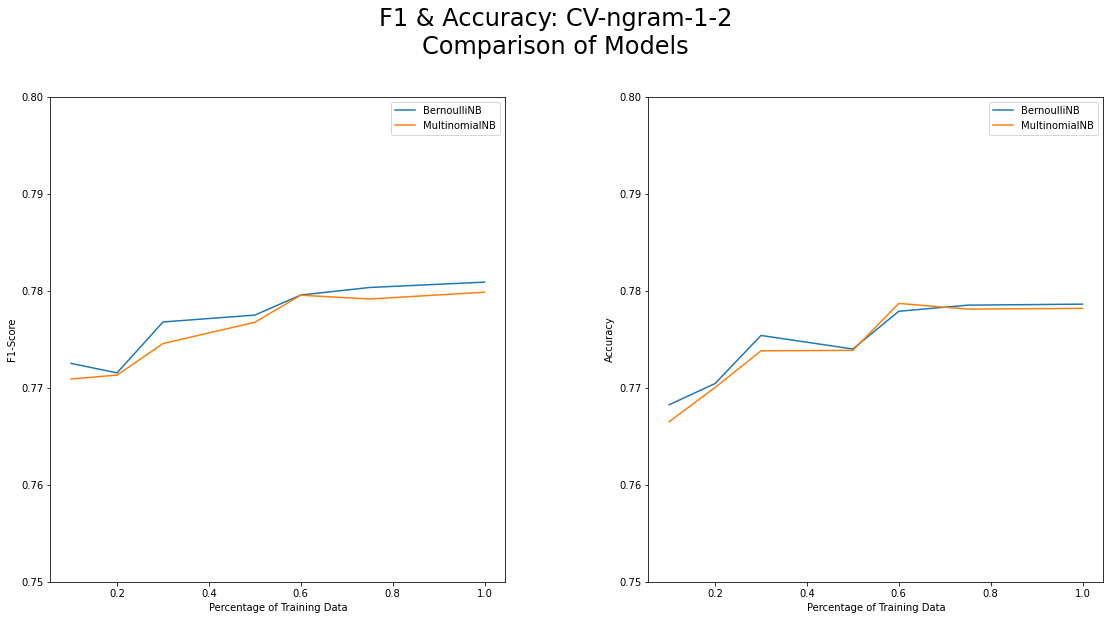

In [27]:
trial_log_df.sort_values(['classifier', 'sample_size'], inplace=True)
for name in sorted(['TFID-ngram-1-2', 'CV-ngram-1-2']):
    fig, axes = plt.subplots(1, 2, figsize=(18,10))
    for ax in axes.ravel():
        # ax.set_xscale('log')
        ax.set_ylim([0.75, 0.80])
        ax.set_yticks([0.75, 0.76, 0.77, 0.78, 0.79, 0.80])
    
    # We are only concerned about the 1-2 n-gram range
    trial_mask = (trial_log_df['trial_name'] == name) & trial_log_df['feature'].str.contains('ngram-1-2')
    # Plot F1
    masked_df = trial_log_df[trial_mask].set_index('sample_size').groupby('classifier')
    masked_df["f1_score"].plot(legend=True, ax=axes[0], xlabel="Percentage of Training Data", ylabel="F1-Score")

    # fig.add_subplot(1, 2, 1)
    # Plot Accuracy on same figure
    masked_df = trial_log_df[trial_mask].set_index('sample_size').groupby('classifier')
    masked_df["accuracy"].plot(legend=True, ax=axes[1], xlabel="Percentage of Training Data", ylabel="Accuracy")
    # fig.add_subplot(1, 2, 2)

    # masked_df = trial_log_df[trial_mask].set_index('sample_size').groupby('classifier')
    fig.tight_layout(pad=10.0)
    fig.suptitle(f"F1 & Accuracy: {name}\nComparison of Models",  fontsize=24)
plt.close()

## Train & Save the Best Model

We will train the best model with the entire set and save the model to a `.joblib` file for deployment.

In [28]:
# We will use the joblib library to save a compressed file format as it works better on numpy array objects
# from joblib import dump, load

# The below cell was used to train final candidate models for deployment

In [29]:
# # Repurpose the samplings memory
# samplings = samples_with_plot(df_processed, sample_sizes=[0.75])
# samplings.append(df_processed.sample(frac=1, random_state=42))
# sample_frames = list(zip(["75","100"], samplings))

# for sample_size, current_frame in sample_frames:
# # Setup the our examples (X) and our target variable (y)
#     X, y = current_frame['unigrams'], current_frame.sentiment

# # TfidfVectorizer with an n-gram range of 1-3 showed the most promising results
# # but ultimately was too costly to put into a production environment with 11M+ features extracted
#     vectorizer = TfidfVectorizer(ngram_range=(1,i+1), min_df=5, max_df=0.95, max_features=250000)
#     X = vectorizer.fit_transform(X)

# Fit the model
#     clf.fit(X, y)
# Pickle the model with gzip for speed / compression tradeoffs
#     dump(clf, f'./models/sent140_bernoulli_{sample_size}.gz', compress=('gzip', 5))
#     dump(vectorizer, f'./models/sent140_tfid_{sample_size}.gz', compress=('gzip', 5))